In [15]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pylab as plt
import scipy

### Read the data

In [35]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [37]:
print train.shape
print test.shape

(114321, 133)
(114393, 132)


In [38]:
train[:3]

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472


### Prepare the data

In [39]:
def prepare_features(data):
    data['NaNCount'] = data.isnull().sum(axis=1)
    data['Mean'] = data.mean(axis=1)
    data['Max'] = data.max(numeric_only=True, axis=1)
    data['Min'] = data.min(numeric_only=True, axis=1)
    data['Std'] = data.std(numeric_only=True, axis=1)
    # data.fillna(-1, inplace=True)

In [40]:
prepare_features(train)
prepare_features(test)

In [41]:
# Replace labels with floats
from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()

for f in test.columns:
    if train[f].dtype=='object':
        lbl_enc.fit(list(train[f])+list(test[f]))
        train[f] = lbl_enc.transform(list(train[f].values))
        test[f] = lbl_enc.transform(list(test[f].values))

In [ ]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='most_frequent') # mean, median
train = pd.DataFrame(imputer.fit_transform(train), columns=train.columns)
test = pd.DataFrame(imputer.fit_transform(test), columns=test.columns)

In [31]:
train[:3]

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v127,v128,v129,v130,v131,NaNCount,Mean,Max,Min,Std
0,3,1,1.335739,8.727474,2,3.921026,7.915266,2.599278,3.176895,0.012941,...,3.113719,2.024285,0,0.636365,2.857144,1,5.052057,19.470199,-6.297423e-07,5.185487
1,4,1,1.630686,7.464411,2,4.145098,9.191265,2.436402,2.483921,2.301630,...,3.239542,1.957825,0,1.925763,1.739389,81,7.217756,81.000000,0.000000e+00,17.943319
2,5,1,0.943877,5.310079,2,4.410969,5.326159,3.979592,3.928571,0.019645,...,3.922193,1.120468,2,0.883118,1.176472,2,4.921187,17.952332,-2.792745e-07,4.636914


### Try RF Regression with K-Best

In [32]:
from sklearn.cross_validation import train_test_split
x_tr, x_cv, y_tr, y_cv = train_test_split(train[test.columns], train.target, test_size = 0.05,  random_state = 42)

In [33]:
%%time
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline

rf = RandomForestRegressor(
    n_estimators=25,
    max_depth=10,
    n_jobs=3,
    random_state=42,
    oob_score=True
)

clf = Pipeline([
  ('feature_selection', SelectKBest(f_regression, k=110)),
  ('classification', rf)
])
clf.fit(x_tr, y_tr)

CPU times: user 2min 56s, sys: 107 ms, total: 2min 57s
Wall time: 1min 2s


In [46]:
%%time
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(
    n_estimators=25,
    max_depth=10,
    n_jobs=3,
    random_state=42,
    oob_score=True
)
clf.fit(x_tr, y_tr)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=3, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [34]:
from sklearn.metrics import log_loss
pred_RF = clf.predict(x_cv)
log_loss(y_cv, pred_RF)

0.46866511261891686

In [13]:
pred_RF[:10]

array([ 0.9836199 ,  0.85443532,  0.36248955,  0.92839414,  0.91778282,
        0.69132322,  0.76051513,  0.97513007,  0.86082516,  0.88250868])

The best: 0.46652821064674577

Feature ranking:


/usr/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


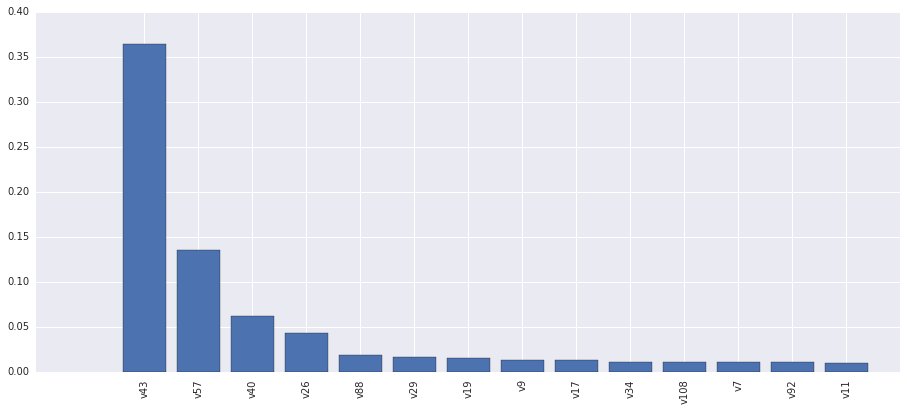

In [16]:
# Show feature importances
importances = rf.feature_importances_
low_value = 0.010
# std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
inds = [i for i in indices if importances[i] > low_value]

print("Feature ranking:")

labels = [list(test.columns)[i] for i in indices.tolist() if importances[i] > low_value]
x = scipy.array(xrange(len(inds)))
y = scipy.array(importances[inds])
f = plt.figure(figsize=(12,5))
ax = f.add_axes([1, 1, 1, 1])
ax.bar(x, y, align='center')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
f.show()

### Submit RF 

In [ ]:
RF = rf.predict(test)

In [ ]:
submit = pd.read_csv('data/sample_submission.csv')
submit.PredictedProb = RF
submit.to_csv('submit.csv', index=False)

### Try XGB 

In [ ]:
from sklearn.cross_validation import train_test_split
x_tr, x_cv, y_tr, y_cv = train_test_split(train[test.columns], train.target, test_size = 0.05,  random_state = 42)

In [18]:
# Set params

params = {"objective": "binary:logistic",
          "booster": "gbtree",
          "eval_metric": "logloss",
          "eta": 0.01,
          "max_depth": 10,
          "subsample": 0.75,
          "colsample_bytree": 0.68,
          "silent": 1
          }
num_trees = 1800
stop = 30
boost_round = 1100

In [19]:
import xgboost as xgb

dtrain = xgb.DMatrix(x_tr.values, y_tr)
dvalid = xgb.DMatrix(x_cv.values, y_cv)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_boost_round=boost_round, evals=watchlist, early_stopping_rounds=stop, verbose_eval=True)

Will train until train error hasn't decreased in 30 rounds.
[0]	eval-logloss:0.689723	train-logloss:0.689566
[1]	eval-logloss:0.686161	train-logloss:0.685768
[2]	eval-logloss:0.682627	train-logloss:0.682017
[3]	eval-logloss:0.679470	train-logloss:0.678633
[4]	eval-logloss:0.675972	train-logloss:0.674881
[5]	eval-logloss:0.672498	train-logloss:0.671171
[6]	eval-logloss:0.669277	train-logloss:0.667647
[7]	eval-logloss:0.665944	train-logloss:0.664052
[8]	eval-logloss:0.662784	train-logloss:0.660683
[9]	eval-logloss:0.659581	train-logloss:0.657202
[10]	eval-logloss:0.656521	train-logloss:0.653866
[11]	eval-logloss:0.653698	train-logloss:0.650846
[12]	eval-logloss:0.650923	train-logloss:0.647868
[13]	eval-logloss:0.647897	train-logloss:0.644594
[14]	eval-logloss:0.645065	train-logloss:0.641568
[15]	eval-logloss:0.642168	train-logloss:0.638431
[16]	eval-logloss:0.639763	train-logloss:0.635838
[17]	eval-logloss:0.636961	train-logloss:0.632824
[18]	eval-logloss:0.634304	train-logloss:0.629945


The best score: 0.454387 (train), 0.45910 (test)

In [20]:
dtest = xgb.DMatrix(test.as_matrix())
XGB = gbm.predict(dtest)
indices = XGB < 0
XGB[indices] = 0

In [21]:
submit = pd.read_csv('data/sample_submission.csv')
submit.PredictedProb = XGB
submit.to_csv('submit.csv', index=False)